In [1]:
from driver import *
from MNIST_LARGE_cfg import *
from pynq import Overlay
import numpy as np
from pynq import Xlnk
import time
import cv2
import matplotlib.pyplot as plt

In [2]:
ol=Overlay("pool_stream.bit")
ol.download();
dma=ol.axi_dma_0
pool=ol.pool_0
conv=ol.Conv_0

In [3]:
xlnk=Xlnk()
image=xlnk.cma_array(shape=(1,28,28,K),cacheable=0,dtype=np.int16)
################# custom param #######################
W_conv1=xlnk.cma_array(shape=(6,5,5,1,K),cacheable=0,dtype=np.int16)
h_conv1=xlnk.cma_array(shape=(1,28,28,K),cacheable=0,dtype=np.int16)
h_pool1=xlnk.cma_array(shape=(1,14,14,K),cacheable=0,dtype=np.int16)

W_conv2=xlnk.cma_array(shape=(16,5,5,1,K),cacheable=0,dtype=np.int16)
h_conv2=xlnk.cma_array(shape=(2,10,10,K),cacheable=0,dtype=np.int16)
h_pool2=xlnk.cma_array(shape=(2,5,5,K),cacheable=0,dtype=np.int16)

W_fc1=xlnk.cma_array(shape=(120,5,5,2,K),cacheable=0,dtype=np.int16)
h_fc1=xlnk.cma_array(shape=(15,1,1,K),cacheable=0,dtype=np.int16)

W_fc2=xlnk.cma_array(shape=(84,1,1,15,K),cacheable=0,dtype=np.int16)
h_fc2=xlnk.cma_array(shape=(11,1,1,K),cacheable=0,dtype=np.int16)

W_fc3=xlnk.cma_array(shape=(10,1,1,11,K),cacheable=0,dtype=np.int16)
h_fc3=xlnk.cma_array(shape=(2,1,1,K),cacheable=0,dtype=np.int16)

In [4]:
Load_Weight_From_File(W_conv1,"record/W_conv1.bin")
Load_Weight_From_File(W_conv2,"record/W_conv2.bin")
Load_Weight_From_File(W_fc1,"record/W_fc1.bin")
Load_Weight_From_File(W_fc2,"record/W_fc2.bin")
Load_Weight_From_File(W_fc3,"record/W_fc3.bin")

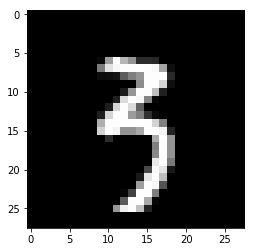

In [5]:
test_pic=699
img_gray=np.zeros((28,28))
with open("MNIST_data/t10k-images.idx3-ubyte",'rb') as fp:
    dat=fp.read(16+28*28*test_pic)
    for i in range(28):
        for j in range(28):
            dat=fp.read(1)
            a=struct.unpack("B",dat)
            img_gray[i][j]=a[0]
            #print(a[0])
img_gray=img_gray.astype(np.uint8)
#print(img_gray)
# for i in range(28):
#     for j in range(28):
#         print("%4d"%img_gray[i][j],end='')
#     print('')
plt.imshow(cv2.merge([img_gray,img_gray,img_gray]))
plt.show()

In [6]:
for i in range(np.shape(img_gray)[0]):
    for j in range(np.shape(img_gray)[1]):
        image[0][i][j][0]=int((img_gray[i][j]/255)*(2**PTR_IMG))

In [7]:
start=time.time()
Run_Conv(conv,1,6,5,5,1,1,1,1,image,PTR_IMG,W_conv1,PTR_W_CONV1,h_conv1,PTR_H_CONV1)
Run_Pool(pool,dma,6,2,2,h_conv1,h_pool1)
Run_Conv(conv,6,16,5,5,1,1,0,1,h_pool1,PTR_H_POOL1,W_conv2,PTR_W_CONV2,h_conv2,PTR_H_CONV2)
Run_Pool(pool,dma,16,2,2,h_conv2,h_pool2)

Run_Conv(conv,16,120,5,5,1,1,0,1,h_pool2,PTR_H_POOL2,W_fc1,PTR_W_FC1,h_fc1,PTR_H_FC1)
Run_Conv(conv,120,84,1,1,1,1,0,1,h_fc1,PTR_H_FC1,W_fc2,PTR_W_FC2,h_fc2,PTR_H_FC2)
Run_Conv(conv,84,10,1,1,1,1,0,0,h_fc2,PTR_H_FC2,W_fc3,PTR_W_FC3,h_fc3,PTR_H_FC3)
end=time.time()
print("Hardware run time=%s s"%(end-start))

Hardware run time=0.023113489151000977 s


In [8]:
max=-32768
num=0
for i in range(10):
    if(h_fc3[i//K][0][0][i%K]>max):
        max=h_fc3[i//K][0][0][i%K]
        num=i;
print("predict num is %d"%num);

predict num is 3


In [6]:
import mnist

In [7]:
_,(x_test, y_test) = mnist.load_data()

In [12]:
x_test = x_test / 255

In [18]:
#image.shape = (1,28,28,8)
image[0,:,:,0] = x_test[0]*(2**PTR_IMG)

In [19]:
start=time.time()
def hw_run(image):
    Run_Conv(conv,1,6,5,5,1,1,1,1,image,PTR_IMG,W_conv1,PTR_W_CONV1,h_conv1,PTR_H_CONV1)
    Run_Pool(pool,dma,6,2,2,h_conv1,h_pool1)
    Run_Conv(conv,6,16,5,5,1,1,0,1,h_pool1,PTR_H_POOL1,W_conv2,PTR_W_CONV2,h_conv2,PTR_H_CONV2)
    Run_Pool(pool,dma,16,2,2,h_conv2,h_pool2)

    Run_Conv(conv,16,120,5,5,1,1,0,1,h_pool2,PTR_H_POOL2,W_fc1,PTR_W_FC1,h_fc1,PTR_H_FC1)
    Run_Conv(conv,120,84,1,1,1,1,0,1,h_fc1,PTR_H_FC1,W_fc2,PTR_W_FC2,h_fc2,PTR_H_FC2)
    Run_Conv(conv,84,10,1,1,1,1,0,0,h_fc2,PTR_H_FC2,W_fc3,PTR_W_FC3,h_fc3,PTR_H_FC3)
end=time.time()
print("Hardware run time=%s s"%(end-start))

Hardware run time=0.0027756690979003906 s


In [20]:
max=-32768
num=0
for i in range(10):
    if(h_fc3[i//K][0][0][i%K]>max):
        max=h_fc3[i//K][0][0][i%K]
        num=i;
print("predict num is %d"%num);

predict num is 3


In [21]:
def hw_run(image):
    Run_Conv(conv,1,6,5,5,1,1,1,1,image,PTR_IMG,W_conv1,PTR_W_CONV1,h_conv1,PTR_H_CONV1)
    Run_Pool(pool,dma,6,2,2,h_conv1,h_pool1)
    Run_Conv(conv,6,16,5,5,1,1,0,1,h_pool1,PTR_H_POOL1,W_conv2,PTR_W_CONV2,h_conv2,PTR_H_CONV2)
    Run_Pool(pool,dma,16,2,2,h_conv2,h_pool2)

    Run_Conv(conv,16,120,5,5,1,1,0,1,h_pool2,PTR_H_POOL2,W_fc1,PTR_W_FC1,h_fc1,PTR_H_FC1)
    Run_Conv(conv,120,84,1,1,1,1,0,1,h_fc1,PTR_H_FC1,W_fc2,PTR_W_FC2,h_fc2,PTR_H_FC2)
    Run_Conv(conv,84,10,1,1,1,1,0,0,h_fc2,PTR_H_FC2,W_fc3,PTR_W_FC3,h_fc3,PTR_H_FC3)

In [17]:
def compare(h_fc3, i):
    max=-32768
    num=0
    for j in range(10):
        #print(j)
        if(h_fc3[j//K][0][0][j%K]>max):
            max=h_fc3[j//K][0][0][j%K]
            num=j
    correct = 1 if num == y_test[i] else 0
    return correct

In [26]:
total_time = 0
correct = 0
for i in range(0,10000):
    image[0,:,:,0]=x_test[i]*(2**PTR_IMG)
    start=time.time()
    hw_run(image)
    end=time.time()
    tmp_time = end - start
    total_time = total_time + tmp_time
    correct = correct + compare(h_fc3, i)
print("total hardware run time=%s s"%(total_time))
print("correct number=%d"%correct)

total hardware run time=178.15291547775269 s
total correct number=9915


In [28]:
def sw_run(image):
    Run_Conv_Soft(1,6,5,5,1,1,1,1,image,PTR_IMG,W_conv1,PTR_W_CONV1,h_conv1,PTR_H_CONV1)
    Run_Pool_Soft(6,2,2,h_conv1,h_pool1)
    Run_Conv_Soft(6,16,5,5,1,1,0,1,h_pool1,PTR_H_POOL1,W_conv2,PTR_W_CONV2,h_conv2,PTR_H_CONV2)
    Run_Pool_Soft(16,2,2,h_conv2,h_pool2)

    Run_Conv_Soft(16,120,5,5,1,1,0,1,h_pool2,PTR_H_POOL2,W_fc1,PTR_W_FC1,h_fc1,PTR_H_FC1)
    Run_Conv_Soft(120,84,1,1,1,1,0,1,h_fc1,PTR_H_FC1,W_fc2,PTR_W_FC2,h_fc2,PTR_H_FC2)
    Run_Conv_Soft(84,10,1,1,1,1,0,0,h_fc2,PTR_H_FC2,W_fc3,PTR_W_FC3,h_fc3,PTR_H_FC3)

In [30]:
total_time = 0
correct = 0
for i in range(0,1):
    image[0,:,:,0]=x_test[i]*(2**PTR_IMG)
    start=time.time()
    sw_run(image)
    end=time.time()
    tmp_time = end - start
    total_time = total_time + tmp_time
    correct = correct + compare(h_fc3, i)
print("1 img software run time=%s s"%(total_time))
print("1 img correct number=%d"%correct)

1 img hardware run time=78.70123338699341 s
1 img correct number=1


In [32]:
total_time = 0
correct = 0
for i in range(0,1):
    image[0,:,:,0]=x_test[i]*(2**PTR_IMG)
    start=time.time()
    hw_run(image)
    end=time.time()
    tmp_time = end - start
    total_time = total_time + tmp_time
    correct = correct + compare(h_fc3, i)
print("1 img hardware run time=%s s"%(total_time))
print("1 img correct number=%d"%correct)

1 img hardware run time=0.026935100555419922 s
1 img correct number=1


In [43]:
import random

In [50]:
random.seed(202007061314)
idx = random.randint(0,19990)
total_time = 0
correct = 0
for i in range(idx,idx+10):
    image[0,:,:,0]=x_test[i]*(2**PTR_IMG)
    start=time.time()
    hw_run(image)
    end=time.time()
    tmp_time = end - start
    total_time = total_time + tmp_time
    correct = correct + compare(h_fc3, i)
print("10 img hardware run time=%s s"%(total_time))
print("10 img correct number=%d"%correct)

10 img hardware run time=0.1803758144378662 s
10 img correct number=10


In [51]:
random.seed(202007061314)
idx = random.randint(0,19990)
total_time = 0
correct = 0
for i in range(idx,idx+10):
    image[0,:,:,0]=x_test[i]*(2**PTR_IMG)
    start=time.time()
    sw_run(image)
    end=time.time()
    tmp_time = end - start
    total_time = total_time + tmp_time
    correct = correct + compare(h_fc3, i)
print("10 img software run time=%s s"%(total_time))
print("10 img correct number=%d"%correct)

10 img software run time=788.3569822311401 s
10 img correct number=8
